## Module 3: Statistical Time Series Methods

Classical models for forecasting structured time series with statistical rigor.

### 3.1 Key Concepts: Stationarity, Autocorrelation, etc.

- A stationary series has constant mean/variance over time.
- Differencing can make a non-stationary series stationary.
- ACF/PACF help spot correlations with lags.

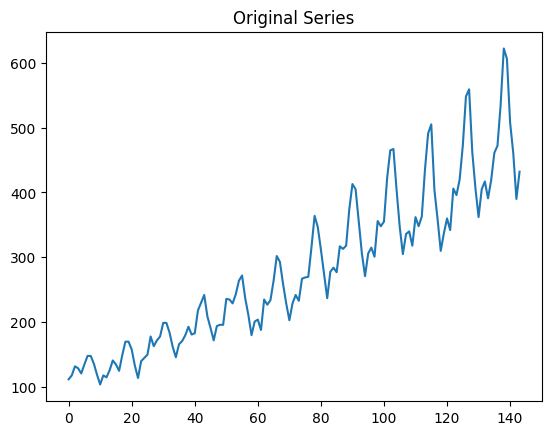

ADF Statistic: 0.8154, p-value: 0.9919


In [8]:
# Load & plot
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
series = df['Passengers']
series.plot(title='Original Series')
plt.show()

# Check stationarity: Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(series)
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

### 3.2 ARIMA Modelling

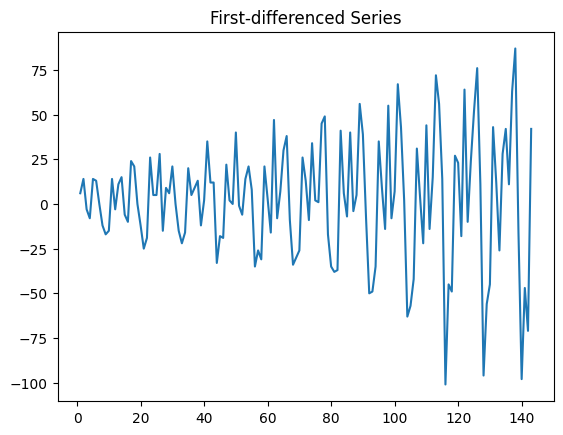

In [9]:
# Differencing for stationarity
diff_series = series.diff().dropna()
diff_series.plot(title='First-differenced Series')
plt.show()

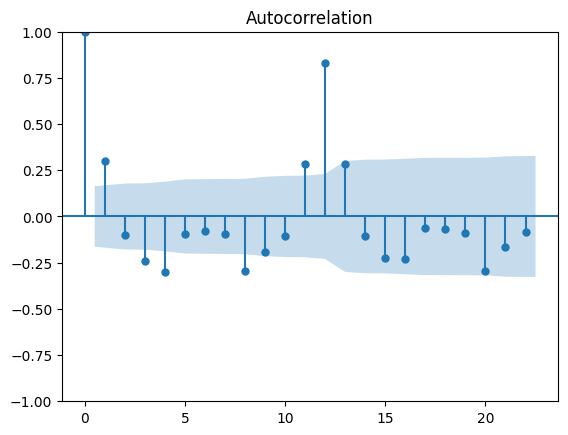

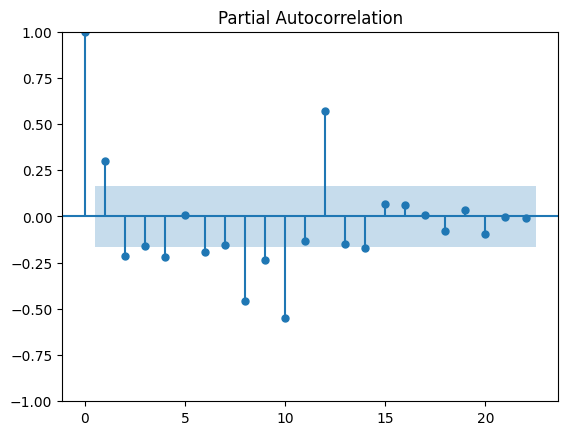

In [10]:
# ACF / PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff_series)
plot_pacf(diff_series)
plt.show()

144    475.735059
145    454.996073
146    464.830415
147    460.167010
148    462.378378
149    461.329756
150    461.827008
151    461.591213
152    461.703026
153    461.650005
154    461.675148
155    461.663225
Name: predicted_mean, dtype: float64


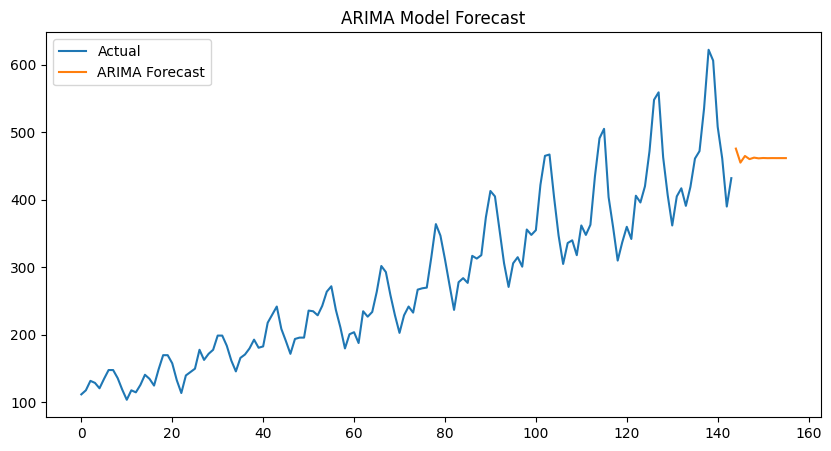

In [11]:
# Fit ARIMA model (example: ARIMA(1,1,1))
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(series, order=(1,1,1)).fit()
forecast_arima = arima_model.forecast(steps=12)
print(forecast_arima)

# Plot actual vs. ARIMA forecast
plt.figure(figsize=(10,5))
series.plot(label='Actual')
plt.plot(range(len(series), len(series)+12), forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()

#### Diagnostics: Residual plots, AIC/BIC, grid search can be further explored.

### 3.3 SARIMA: Seasonal ARIMA

144    449.330279
145    424.386579
146    459.033946
147    497.865829
148    509.863907
149    568.258866
150    655.811130
151    641.191501
152    546.393768
153    496.801933
154    427.675604
155    471.237459
Name: predicted_mean, dtype: float64


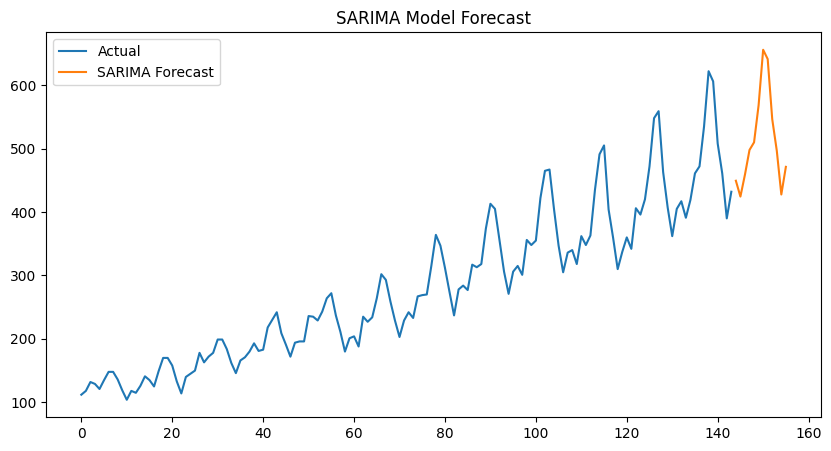

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(steps=12)
print(sarima_forecast)

# Plot actual vs. ARIMA forecast
plt.figure(figsize=(10,5))
series.plot(label='Actual')
plt.plot(range(len(series), len(series)+12), sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Model Forecast')
plt.show()

### 3.4 Prophet: Trend, Seasonality, & Holidays

03:35:07 - cmdstanpy - INFO - Chain [1] start processing
03:35:07 - cmdstanpy - INFO - Chain [1] done processing


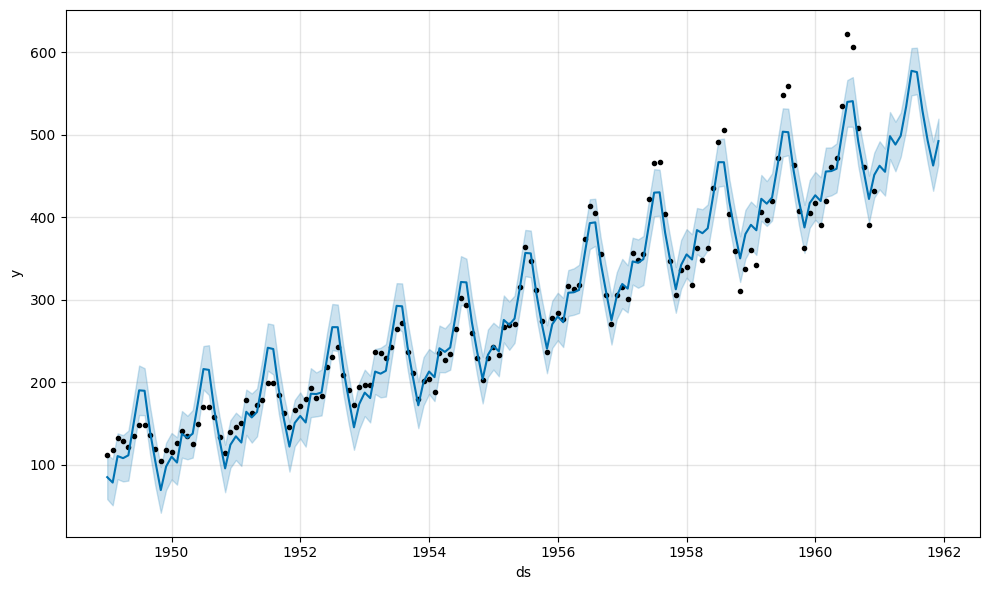

In [15]:
# Note: Install prophet via pip if needed: pip install prophet
from prophet import Prophet
df_prophet = df.rename(columns={'Month': 'ds', 'Passengers': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)
fig = model.plot(forecast)

### 3.5 Other Classical Models (VAR, State Space, hint only; see docs)
#### VAR (for multi-variate; e.g. add more columns to df)
#### State Space Models & Kalman Filter (notebook references/links for advanced study)

### 3.6 Mini-Project
1. Choose a time series dataset
2. Test for stationarity (ADF)
3. Fit/tune ARIMA, SARIMA, Prophet
4. Forecast future values, visualize
5. Compare to module 2 baselines

### 3.7 Next Up
Machine Learning for forecasting!